# Image Detection on FER2013 with InceptionV3

In this notebook, we are going to use Inception V3 trained based on ImageNet to detect emotions on the FER2013 images.   
The FER2013 dataset can be found here:
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

A large percent of this code is compiled from external sources:
https://github.com/DeepLearningSandbox/DeepLearningSandbox/tree/master/transfer_learning


In [1]:
import os
import sys
import glob
import argparse
from keras import __version__, backend
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import tensorflow as tf

import numpy as np
import requests
from io import BytesIO

from PIL import Image,ImageDraw,ImageFont
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
sys.executable

backend.tensorflow_backend._get_available_gpus()


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### A few helper functions to set up our model

In [2]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

For transfer learning, we are only going to unfreeze the last prediction layer and retrain it using the new data. We are not adding new layers to the inception net

In [3]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=predictions)
    return model

In addition to fitting the last layer, we will also be refining the model by freeing up the last two inception blocks and retraining them to further improve the model performance.

In [5]:
def setup_to_finetune(model):
    """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
    note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
    Args:
    model: keras model
    """
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

### Define training algorithm
Instead of using a seperate validation file, we are splitting 20% of the original FER2013 training data as our validation dataset.

## Setting parameters

In [7]:
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 50
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172

train_data_dir = "/data/Training"

#### Visualize pictures

Found 22968 images belonging to 7 classes.
Found 5740 images belonging to 7 classes.
(32, 299, 299, 1)
(299, 299, 1)


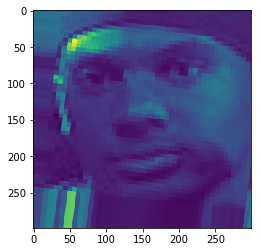

In [8]:
# try another image generator to match Arriaga implementation
# https://github.com/oarriaga
data_generator = ImageDataGenerator(
                        preprocessing_function=preprocess_input,
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True,
                        validation_split=0.2)
    
train_generator = data_generator.flow_from_directory(
train_data_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=BAT_SIZE,
subset='training',
color_mode="grayscale")

validation_generator = data_generator.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BAT_SIZE,
    subset='validation',
color_mode="grayscale")

x,y = train_generator.next()
print(x.shape)
image = x[2]
print(image.shape)
plt.imshow(image.reshape(IM_WIDTH, IM_HEIGHT))
plt.show()

In [20]:
def train_64(train_dir, nb_epoch,batch_size, out_dir):
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    nb_train_samples = get_nb_files(train_dir)
    nb_classes = 7
    nb_epoch = int(nb_epoch)
    batch_size = int(batch_size)
    # data prep
    data_generator = ImageDataGenerator(
                            preprocessing_function=preprocess_input,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=.1,
                            horizontal_flip=True,
                            validation_split=0.2)

    train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    subset='training')

    validation_generator = data_generator.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    subset='validation')

    # setup model
    base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    
    # transfer learning
    setup_to_transfer_learn(model, base_model)

    # Save the model according to the conditions  
    checkpoint = ModelCheckpoint(out_dir, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')    
 
    history_tl = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    nb_epoch=nb_epoch,
    samples_per_epoch=nb_train_samples,
    class_weight='auto',
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,           
    callbacks = [checkpoint, early, TensorBoard("/data/tf_log")])
    
    
    # fine-tuning
    setup_to_finetune(model)
    history_ft = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    nb_epoch=nb_epoch,
    class_weight='auto',
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,    

    callbacks = [checkpoint, early, TensorBoard("/data/tf_log")])
    model.save(out_dir)
  

Activate tensorboard in logdir="/data/inception" to view training progress.

In [ ]:
train_64(train_dir = train_data_dir, nb_epoch= NB_EPOCHS, batch_size=BAT_SIZE, out_dir = "/data/inception_64" )

Found 22968 images belonging to 7 classes.
Found 5740 images belonging to 7 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., class_weight="auto", validation_data=<keras_pre..., validation_steps=179, callbacks=[<keras.ca..., epochs=50, steps_per_epoch=897)`


Epoch 1/50
897/897 [==============================] - 659s 735ms/step - loss: 2.9176 - acc: 0.2713 - val_loss: 1.7329 - val_acc: 0.2924

Epoch 00001: val_loss improved from inf to 1.73288, saving model to /data/inception_64
Epoch 2/50
897/897 [==============================] - 652s 727ms/step - loss: 1.6620 - acc: 0.3362 - val_loss: 1.7165 - val_acc: 0.3134

Epoch 00002: val_loss improved from 1.73288 to 1.71645, saving model to /data/inception_64
Epoch 3/50
897/897 [==============================] - 646s 720ms/step - loss: 1.6303 - acc: 0.3561 - val_loss: 1.9965 - val_acc: 0.2812

Epoch 00003: val_loss did not improve from 1.71645
Epoch 4/50
897/897 [==============================] - 650s 725ms/step - loss: 1.6145 - acc: 0.3638 - val_loss: 1.7908 - val_acc: 0.2999

Epoch 00004: val_loss did not improve from 1.71645
Epoch 5/50
897/897 [==============================] - 650s 724ms/step - loss: 1.6055 - acc: 0.3682 - val_loss: 1.9124 - val_acc: 0.3038

Epoch 00005: val_loss did not impro

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:63: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., class_weight="auto", validation_data=<keras_pre..., validation_steps=179, steps_per_epoch=717, callbacks=[<keras.ca..., epochs=50)`


Epoch 1/50
717/717 [==============================] - 548s 765ms/step - loss: 1.4963 - acc: 0.4207 - val_loss: 1.6803 - val_acc: 0.3402

Epoch 00001: val_loss improved from 1.71645 to 1.68034, saving model to /data/inception_64
Epoch 2/50
717/717 [==============================] - 538s 751ms/step - loss: 1.4070 - acc: 0.4561 - val_loss: 1.6243 - val_acc: 0.3625

Epoch 00002: val_loss improved from 1.68034 to 1.62429, saving model to /data/inception_64
Epoch 3/50
717/717 [==============================] - 540s 753ms/step - loss: 1.3500 - acc: 0.4839 - val_loss: 1.6447 - val_acc: 0.3574

Epoch 00003: val_loss did not improve from 1.62429
Epoch 4/50
717/717 [==============================] - 539s 752ms/step - loss: 1.3156 - acc: 0.4960 - val_loss: 1.5523 - val_acc: 0.3949

Epoch 00004: val_loss improved from 1.62429 to 1.55234, saving model to /data/inception_64
Epoch 5/50
717/717 [==============================] - 541s 754ms/step - loss: 1.2766 - acc: 0.5118 - val_loss: 1.5477 - val_acc:

In [12]:
def continue_train(train_dir, nb_epoch,batch_size, out_dir):
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    nb_train_samples = get_nb_files(train_dir)
    nb_classes = 7
#     nb_val_samples = get_nb_files(args.val_dir)
    nb_epoch = int(nb_epoch)
    batch_size = int(batch_size)
    # data prep
    train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
    
#     test_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
#     )
    
    train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    )
#     validation_generator = test_datagen.flow_from_directory(
#     args.val_dir,
#     target_size=(IM_WIDTH, IM_HEIGHT),
#     batch_size=batch_size,
#     )
    # setup model
    base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
        # Save the model according to the conditions  
    checkpoint = ModelCheckpoint(out_dir, monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='acc', min_delta=0, patience=10, verbose=1, mode='auto')

    cont_model = load_model("/data/inception")
    
    history_tl = cont_model.fit_generator(
    train_generator,
    nb_epoch=nb_epoch,
    samples_per_epoch=nb_train_samples,
#     validation_data=validation_generator,
#     nb_val_samples=nb_val_samples,
    class_weight='auto',
    callbacks = [checkpoint, early])
    
    # fine-tuning
    setup_to_finetune(cont_model)
    history_ft = cont_model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    nb_epoch=nb_epoch,
#     validation_data=validation_generator,
#     nb_val_samples=nb_val_samples,
    class_weight='auto',
    callbacks = [checkpoint, early])
    
    model.save(out_dir)
 
 

In [ ]:
continue_train(train_dir = train_data_dir, nb_epoch= 15, batch_size=BAT_SIZE, out_dir = "/data/inception" )

Found 28707 images belonging to 7 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:58: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:58: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., class_weight="auto", steps_per_epoch=2870, callbacks=[<keras.ca..., epochs=15)`


Epoch 1/15
2870/2870 [==============================] - 609s 212ms/step - loss: 1.6790 - acc: 0.3383

Epoch 00001: acc improved from -inf to 0.33826, saving model to /data/inception
Epoch 2/15
2870/2870 [==============================] - 604s 211ms/step - loss: 1.6731 - acc: 0.3368

Epoch 00002: acc did not improve from 0.33826
Epoch 3/15
2870/2870 [==============================] - 606s 211ms/step - loss: 1.6762 - acc: 0.3369

Epoch 00003: acc did not improve from 0.33826
Epoch 4/15
2870/2870 [==============================] - 614s 214ms/step - loss: 1.6773 - acc: 0.3380

Epoch 00004: acc did not improve from 0.33826
Epoch 5/15
2870/2870 [==============================] - 616s 215ms/step - loss: 1.6755 - acc: 0.3398

Epoch 00005: acc improved from 0.33826 to 0.33976, saving model to /data/inception
Epoch 6/15
2870/2870 [==============================] - 603s 210ms/step - loss: 1.6828 - acc: 0.3392

Epoch 00006: acc did not improve from 0.33976
Epoch 7/15
2870/2870 [===================

In [11]:
def continue_finetune(train_dir, nb_epoch,batch_size, out_dir):
    """Use transfer learning and fine-tuning to train a network on a new dataset"""
    nb_train_samples = get_nb_files(train_dir)
    nb_classes = 7
#     nb_val_samples = get_nb_files(args.val_dir)
    nb_epoch = int(nb_epoch)
    batch_size = int(batch_size)
    # data prep
    train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
    
#     test_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
#     )
    
    train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    )
#     validation_generator = test_datagen.flow_from_directory(
#     args.val_dir,
#     target_size=(IM_WIDTH, IM_HEIGHT),
#     batch_size=batch_size,
#     )
    # setup model
    base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
        # Save the model according to the conditions  
    checkpoint = ModelCheckpoint(out_dir, monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='acc', min_delta=0, patience=10, verbose=1, mode='auto')

    cont_model = load_model("/data/inception")
    
    # fine-tuning
    setup_to_finetune(cont_model)
    history_ft = cont_model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    nb_epoch=nb_epoch,
    validation_data=validation_generator,
    class_weight='auto',
    callbacks = [checkpoint, early])
    
 
 

In [12]:
continue_finetune(train_dir = train_data_dir, nb_epoch= 15, batch_size=BAT_SIZE, out_dir = "/data/inception" )

Found 28707 images belonging to 7 classes.
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:60: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=2870, class_weight="auto", callbacks=[<keras.ca..., epochs=15)`


Epoch 1/15
2870/2870 [==============================] - 619s 216ms/step - loss: 1.6005 - acc: 0.3783

Epoch 00001: acc improved from -inf to 0.37833, saving model to /data/inception
Epoch 2/15
2870/2870 [==============================] - 608s 212ms/step - loss: 1.4970 - acc: 0.4271

Epoch 00002: acc improved from 0.37833 to 0.42708, saving model to /data/inception
Epoch 3/15
2870/2870 [==============================] - 608s 212ms/step - loss: 1.4402 - acc: 0.4543

Epoch 00003: acc improved from 0.42708 to 0.45433, saving model to /data/inception
Epoch 4/15
2870/2870 [==============================] - 609s 212ms/step - loss: 1.3984 - acc: 0.4664

Epoch 00004: acc improved from 0.45433 to 0.46639, saving model to /data/inception
Epoch 5/15
2870/2870 [==============================] - 609s 212ms/step - loss: 1.3642 - acc: 0.4834

Epoch 00005: acc improved from 0.46639 to 0.48336, saving model to /data/inception
Epoch 6/15
2870/2870 [==============================] - 609s 212ms/step - loss

In [ ]:
checkpoint = ModelCheckpoint(out_dir, monitor='acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='acc', min_delta=0, patience=10, verbose=1, mode='auto')



history_tl = new_model.fit_generator(
train_generator,
nb_epoch=nb_epoch,
samples_per_epoch=nb_train_samples,
#     validation_data=validation_generator,
#     nb_val_samples=nb_val_samples,
class_weight='auto',
callbacks = [checkpoint, early])
    